In [30]:
import gensim
import keras
import numpy as np
import pandas as pd
import pickle
import warnings
warnings.filterwarnings("ignore")


from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, BatchNormalization, Activation, Bidirectional
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences


import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
from keras.utils import plot_model 
from IPython.display import Image
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.preprocessing import LabelEncoder



np.random.seed(1003)

In [31]:
W2V_DIR = 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'
DATA_DIR = ''
Glove = 'glove.6B.100d.txt'

# These are some hyperparameters that can be tuned
MAX_SENT_LEN = 170
MAX_VOCAB_SIZE = 400000
LSTM_DIM = 128
EMBEDDING_DIM = 100
BATCH_SIZE = 200
N_EPOCHS = 10

In [32]:
train_bodies = pd.read_csv(DATA_DIR+'train_bodies.csv')
train_stances = pd.read_csv(DATA_DIR+'train_stances.csv')

test_bodies = pd.read_csv(DATA_DIR+'test_bodies.csv')
test_stances_unlabeled = pd.read_csv(DATA_DIR+'test_stances_unlabeled.csv')

In [33]:
train = train_stances.join(train_bodies.set_index('Body ID'), on='Body ID')
test = test_stances_unlabeled.join(test_bodies.set_index('Body ID'), on='Body ID')

In [34]:
train.replace('unrelated',1,True)
train.replace('agree',2,True)
train.replace('disagree',3,True)
train.replace('discuss',4,True)

In [35]:
word_seq_headline_train = [text_to_word_sequence(sent) for sent in train['Headline']]
word_seq_bodies_train = [text_to_word_sequence(sent) for sent in train['articleBody']]

word_seq_headline_test = [text_to_word_sequence(sent) for sent in test['Headline']]
word_seq_bodies_test = [text_to_word_sequence(sent) for sent in test['articleBody']]

In [36]:
word_seq = []
for i in range(len(word_seq_headline_train)):
  word_seq.append(word_seq_headline_train[i])
  
for i in range(len(word_seq_bodies_train)):
  word_seq.append(word_seq_bodies_train[i])

for i in range(len(word_seq_headline_test)):
  word_seq.append(word_seq_headline_test[i])

for i in range(len(word_seq_bodies_test)):
  word_seq.append(word_seq_bodies_test[i])

In [37]:
for i in range (len(word_seq_headline_train)):
  word_seq_headline_train[i].extend(word_seq_bodies_train[i])

  
for i in range (len(word_seq_headline_test)):
  word_seq_headline_test[i].extend(word_seq_bodies_test[i])

In [38]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq])

In [39]:
# Convert the sequence of words to sequnce of indices
X_train = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq_headline_train])
X_train = pad_sequences(X_train, maxlen=MAX_SENT_LEN, padding='post', truncating='post')
y_train = train['Stance']
y_train = y_train.values


In [40]:
from keras.utils import np_utils

encoder_train = LabelEncoder()
encoder_train.fit(y_train)
encoded_train = encoder_train.transform(y_train)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = np_utils.to_categorical(encoded_train)

In [41]:
X_train, X_val, y_train, y_val = train_test_split(X_train, dummy_y_train, random_state=10, test_size=0.1)


In [42]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove2word2vec(glove_input_file="glove.6B.100d.txt", word2vec_output_file="gensim_glove_vectors.txt")

embeddings = gensim.models.KeyedVectors.load_word2vec_format("gensim_glove_vectors.txt", binary=False)

embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(tokenizer.word_index)+1, EMBEDDING_DIM)) # +1 is because the matrix indices start with 0

for word, i in tokenizer.word_index.items(): # i=0 is the embedding for the zero padding
    try:
        embeddings_vector = embeddings[word]
    except KeyError:
        embeddings_vector = None
    if embeddings_vector is not None:
        embeddings_matrix[i] = embeddings_vector
        
del embeddings

In [43]:

# Build a sequential model by stacking neural net units 
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=EMBEDDING_DIM,
                          weights = [embeddings_matrix], trainable=False, name='word_embedding_layer' 
                          ))
model.add(Bidirectional(LSTM(LSTM_DIM, return_sequences=False, name='Bidrectional_lstm_layer1')))
model.add(Dropout(rate=0.5, name='dropout_1')) # Can try varying dropout rates, in paper suggest 0.8
model.add(Dense(4, activation='softmax', name='output_layer'))
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding_layer (Embedd (None, None, 100)         2238100   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               234496    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
output_layer (Dense)         (None, 4)                 1028      
Total params: 2,473,624
Trainable params: 235,524
Non-trainable params: 2,238,100
_________________________________________________________________
None


In [44]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

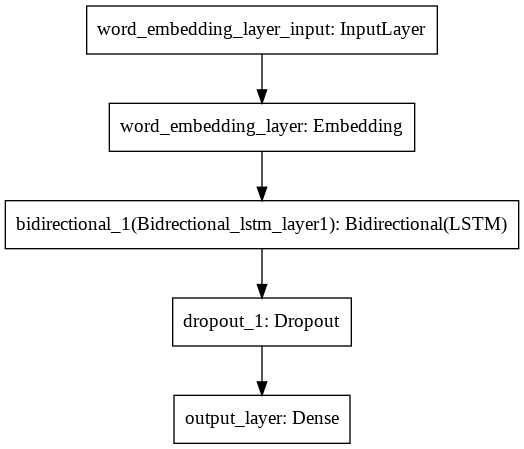

In [45]:
keras.utils.plot_model(model, show_shapes=False)


In [46]:
history = model.fit(X_train, y_train,
          batch_size=100,
          epochs=20,
          validation_data=(X_val, y_val))

Train on 44974 samples, validate on 4998 samples
Epoch 1/20
44974/44974 [==============================] - 482s 11ms/step - loss: 0.7213 - accuracy: 0.7391 - val_loss: 0.6271 - val_accuracy: 0.7551
Epoch 2/20
44974/44974 [==============================] - 483s 11ms/step - loss: 0.5294 - accuracy: 0.7938 - val_loss: 0.4240 - val_accuracy: 0.8341
Epoch 3/20
44974/44974 [==============================] - 485s 11ms/step - loss: 0.3834 - accuracy: 0.8526 - val_loss: 0.3466 - val_accuracy: 0.8679
Epoch 4/20
44974/44974 [==============================] - 477s 11ms/step - loss: 0.2997 - accuracy: 0.8854 - val_loss: 0.2985 - val_accuracy: 0.8848
Epoch 5/20
44974/44974 [==============================] - 480s 11ms/step - loss: 0.2410 - accuracy: 0.9085 - val_loss: 0.2462 - val_accuracy: 0.9100
Epoch 6/20
44974/44974 [==============================] - 465s 10ms/step - loss: 0.1975 - accuracy: 0.9252 - val_loss: 0.2186 - val_accuracy: 0.9218
Epoch 7/20
44974/44974 [==============================] -

In [47]:
with open('BILSTM_glove', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

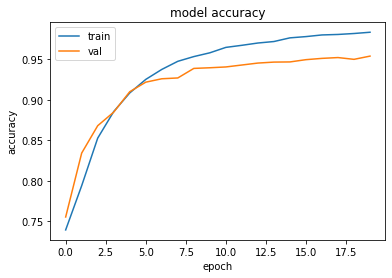

In [48]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [49]:
competetion_bodies = pd.read_csv(DATA_DIR+'competition_test_bodies.csv')
competetion_stances = pd.read_csv(DATA_DIR+'competition_test_stances.csv')

competetion_unlabeled = pd.read_csv(DATA_DIR+'competition_test_stances_unlabeled.csv')

comp = competetion_stances.join(competetion_bodies.set_index('Body ID'), on='Body ID')
comp.replace('unrelated',1,True)
comp.replace('agree',2,True)
comp.replace('disagree',3,True)
comp.replace('discuss',4,True)

word_seq_headline_comp = [text_to_word_sequence(sent) for sent in comp['Headline']]
word_seq_bodies_comp = [text_to_word_sequence(sent) for sent in comp['articleBody']]

for i in range (len(word_seq_headline_comp)):
  word_seq_headline_comp[i].extend(word_seq_bodies_comp[i])

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq_headline_comp])

X_comp = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq_headline_comp])
X_comp = pad_sequences(X_comp, maxlen=MAX_SENT_LEN, padding='post', truncating='post')
y_comp = comp['Stance']
y_comp = y_comp.values

encoder_comp = LabelEncoder()
encoder_comp.fit(y_comp)
encoded_comp = encoder_comp.transform(y_comp)
dummy_y_comp = np_utils.to_categorical(encoded_comp)

y_Uni = model.predict(X_comp)
score,acc = model.evaluate(X_comp, dummy_y_comp)

25413/25413 [==============================] - 69s 3ms/step


In [50]:
from score import report_score
outputs = [np.argmax(p) for p in y_Uni]

for i in range(len(outputs)):
    if outputs[i] == 0: outputs[i] = "unrelated"
    if outputs[i] == 1: outputs[i] = "disagree"
    if outputs[i] == 2: outputs[i] = "agree"
    if outputs[i] == 3: outputs[i] = "discuss"
#print (np.unique(outputs))

cs = pd.read_csv(DATA_DIR+'competition_test_stances.csv')
stance_true = cs['Stance'].values
from score import report_score
print ("Weighted Score")
report_score(stance_true, outputs)

Predicted = {}
Predicted = pd.DataFrame({'Stance': outputs})
result = pd.concat([competetion_unlabeled, Predicted], axis=1, sort=False)
result.to_csv('submission_BILSTM_glove.csv', index=False, encoding='utf-8')

Weighted Score
-------------------------------------------------------------
|           |   agree   | disagree  |  discuss  | unrelated |
-------------------------------------------------------------
|   agree   |     5     |    89     |    197    |   1612    |
-------------------------------------------------------------
| disagree  |     6     |    27     |    85     |    579    |
-------------------------------------------------------------
|  discuss  |    24     |    189    |    517    |   3734    |
-------------------------------------------------------------
| unrelated |    48     |    690    |   1750    |   15861   |
-------------------------------------------------------------
Score: 4661.75 out of 11651.25	(40.01072846261131%)
